In this notebook, we evaluate the possibility of using graph kernel attacks against TUDatasets. We focus on datasets with privacy applications.

We modify this notebook by comparing with another attack.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tapas.datasets
import tapas.generators
import tapas.threat_models
import tapas.attacks

In [2]:
np.random.seed(13121)

## Real-world private datasets

The COLLAB dataset contains collaboration networks of academics. They are ego networks for these academics.

In [3]:
# If you have not yet downloaded the dataset:
# data = tapas.datasets.TUDataset.download_and_read("COLLAB")

# Otherwise:
# data = tapas.datasets.TUDataset.read("COLLAB", "COLLAB")

In [4]:
data = tapas.datasets.TUDataset.read("deezer_ego_nets", "deezer_ego_nets")

Loading TU graph dataset: deezer_ego_nets


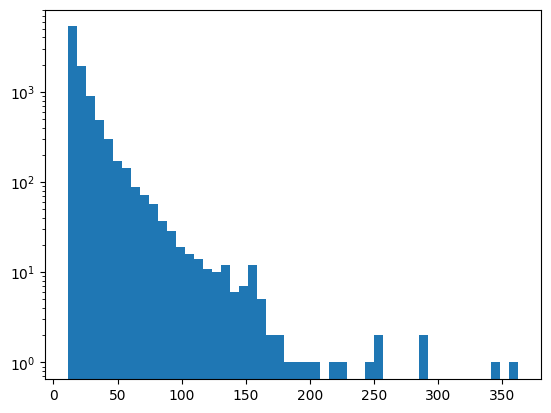

In [5]:
plt.hist([len(g.nodes()) for g in data.data], 50)
plt.yscale('log')

## Memoized kernels

In our attacks, the main blocker is that kernels are computed many times over the same graph, leading to massive performance overheads. Memoization is the key here.

Importantly, we do not check whether graphs are identical, but merely whether they are stored in the same location in memory.

We also use this class to provide a clean interface between grakel kernels and networkx data.

In [6]:
import networkx as nx
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [7]:
class Memoize:
    def __init__(self, kernel):
        self.kernel = kernel
        self.memory = {}
    
    def fit(self, tudataset):
        self.memory = {}  # Fitting the kernel resets the memory.
        self.kernel.fit(_grak(tudataset.data))

    def transform(self, tudataset):
        # Use G for the key, and grak(G) for the feature transformation.
        for G in tudataset.data:
            if G not in self.memory:
                self.memory[G] = self.kernel.transform(_grak([G]))[0]
        return np.stack([self.memory[G] for G in tudataset.data])

    def fit_transform(self, tudataset):        
        self.fit(tudataset)
        return self.transform(tudataset)

We now instantiate a typical kernel.

In [8]:
from grakel import WeisfeilerLehman, VertexHistogram

# TODO: find a better kernel -- vertex histogram is silly here, since there is very little (no?) overlap.
# We address this by relabelling nodes to 1..num_nodes.
kernel = Memoize(WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True))

## Threat modelling (typical TAPAS)

We attack the Raw generator, for simplicity. This should be trivially attackable!

In [9]:
generator = tapas.generators.Raw()

We select arbitrary target(s) in the dataset.

In [10]:
target_indices = [0]

target_records = data.get_records(target_indices)
data.drop_records(target_indices, in_place=True)

We choose the auxiliary dataset setup (the attacker has access to a large number of real records disjoint from the real dataset).

In [11]:
size_private_dataset = 100
size_synthetic_dataset = 100
train_test_split = 0.5

In [12]:
threat_model = tapas.threat_models.TargetedMIA(
    attacker_knowledge_data = tapas.threat_models.AuxiliaryDataKnowledge(
        data, auxiliary_split=train_test_split, num_training_records=size_private_dataset,
    ),
    target_record = target_records,
    attacker_knowledge_generator=tapas.threat_models.BlackBoxKnowledge(
        generator, num_synthetic_records=size_synthetic_dataset,
    ),
    generate_pairs=False,
    replace_target=True,
)

## Attacks

We first define a few items that will be useful for attacking graphs.

In [13]:
class KernelFeature(tapas.attacks.SetFeature):
    """Extract some features from a graph, using a specific kernel."""
    
    def __init__(self, kernel):
        self.kernel = kernel
    
    def fit(self, tudataset):
        """Fit the kernel used by this feature using a dataset."""
        self.kernel.fit(tudataset)
    
    def extract(self, datasets):
        return np.stack([
            self.kernel.transform(d).mean(axis=0)
            for d in datasets
        ])

In [14]:
class KernelBasedDistance(tapas.attacks.DistanceMetric):
    """L2 distance between the kernels of two graphs."""

    def __init__(self, kernel):
        self.kernel = kernel
        self._label = 'KernelBasedDistance'

    def fit(self, tudataset):
        """Fit the kernel used by this feature using a dataset."""
        self.kernel.fit(tudataset)

    def __call__(self, x, y):
        # Compute the distance matrix between two TUDatasets.
        ft_x = self.kernel.transform(x)
        ft_y = self.kernel.transform(y)
        dists = np.zeros((len(x), len(y)))
        for i, x1 in enumerate(ft_x):
            for j, x2 in enumerate(ft_y):
                dists[i,j] = np.linalg.norm(x1 - x2)
        return dists

#### Trained kernel

We use a fraction of the auxiliary dataset exclusively to fit the kernel. It is then discarded.

In [15]:
# A bit wordy, but we can extract the auxiliary data of the attacker as:
auxiliary_data = threat_model.atk_know_data.attacker_knowledge.aux_data

# We select a number of these graphs (200, for fun) which are dropped from the dataset.
# These records will be used exclusively to train the kernel.
kernel_training_data = auxiliary_data.create_subsets(n=1, sample_size = 200, drop_records=True)[0]

In [16]:
kernel.fit(kernel_training_data);

Pre-compute graph kernels (for fast computations)!

In [17]:
kernel.transform(data);

### Distance-based attack

In [18]:
dist = KernelBasedDistance(kernel)

In [19]:
attack = tapas.attacks.ClosestDistanceMIA(distance = dist, criterion = "accuracy")

In [20]:
# Training selects a threshold for the attack.
attack.train(threat_model, num_samples=100)

In [21]:
summary = threat_model.test(attack, num_samples=100)

In [22]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Raw,"ClosestDistance(KernelBasedDistance, accuracy)",1.0,1.0,0.0,1.0,0.0,1.0,inf


As expected for the RAW generator, this attack achieves 100% accuracy (since there is a record within distance $0$ if and only if the target is in the dataset).

### Shadow-modelling attack

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

In [24]:
attack = tapas.attacks.ShadowModellingAttack(
    tapas.attacks.FeatureBasedSetClassifier(
        features = KernelFeature(kernel),
        classifier = RandomForestClassifier(),
    )
)

We first train with a small number of records. It actually works kind of well!

In [25]:
# This involves feature extraction and training a model.
attack.train(threat_model, num_samples=100)

In [26]:
summary = threat_model.test(attack, num_samples=1000)

In [27]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Raw,"ShadowModelling(Classifier(Unknown SetFeature,...",0.638,0.50303,0.229703,0.273327,0.726673,0.659534,1.925909


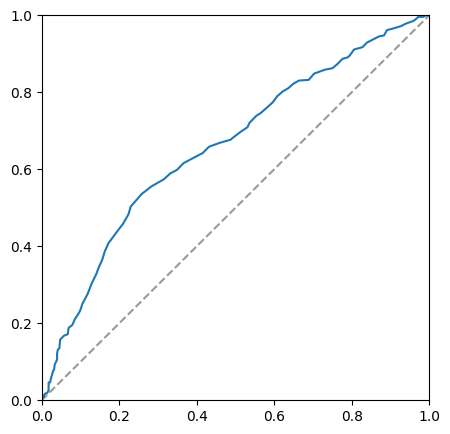

In [28]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

We now train with a *very* large number of samples. Now the shadow-modelling attack works very well!

In [29]:
attack.train(threat_model, num_samples=10000)

In [30]:
summary = threat_model.test(attack, num_samples=1000)

In [31]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Raw,"ShadowModelling(Classifier(Unknown SetFeature,...",0.792,0.80202,0.217822,0.584198,0.415802,0.873545,inf


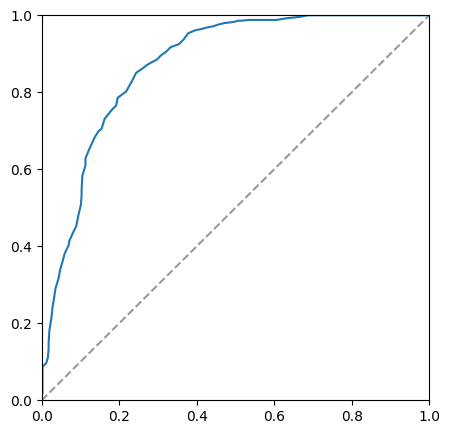

In [32]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

### Composed graph classifier

We now use our custom composed graph classifier (using the same parameters otherwise). Note that this is very slow, since the kernel needs to be recomputed for every dataset.

Surprisingly, this works very well, almost as well as distance-based attack (although it is noticeably slower), even with a small number of samples.

In [33]:
attack = tapas.attacks.ShadowModellingAttack(
    tapas.attacks.ComposedGraphClassifier(
        classifier = RandomForestClassifier(),
        # Remove all memoization (this expects a grakel.Kernel).
        kernel = kernel.kernel
    ),
    label = 'ComposedAttack'
)

In [34]:
attack.train(threat_model, num_samples=100)

In [35]:
summary = threat_model.test(attack, num_samples=1000)

In [36]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Raw,ComposedAttack,0.939,0.915152,0.037624,0.877528,0.122472,0.987177,inf


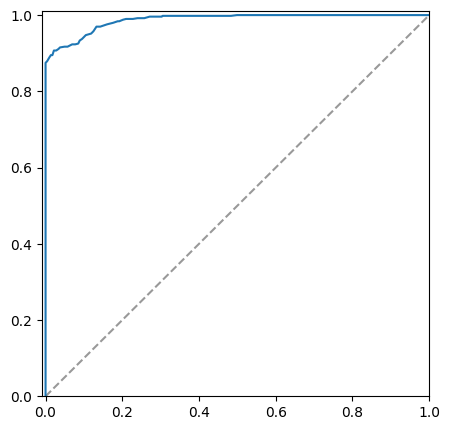

In [45]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

## Multi-target model

For this, for each synthetic dataset, we need to recover its training set, and find records which were _not_ in that set.

In [47]:
auxiliary_data = threat_model.atk_know_data.attacker_knowledge.aux_data

In [69]:
synth_datasets_train, _ = threat_model.generate_training_samples(100)

In [71]:
synth_datasets_test, _ = threat_model._generate_samples(100, training=False)

For each real dataset, sample a dataset of same size of records that are _not_ in the real data. Transform these in lists of features `X` and labels `y` (this is merely a data structure change).

In [68]:
def extract_features_and_labels(auxiliary_data, synth_datasets, real_datasets):
    negative_datasets = []
    for dataset in real_datasets:
        # Use twice as many samples to make sure we have enough.
        candidates = auxiliary_data.sample(2*len(dataset))
        # Find all candidates that are *not* in the dataset.
        indices_to_keep = []
        for idx, record in enumerate(candidates):
            # Check if the record is in the real (or synthetic lol) dataset.
            if record in dataset:
                continue
            indices_to_keep.append(idx)
            if len(indices_to_keep) >= len(dataset):
                break
        negative_datasets.append(candidates.get_records(indices_to_keep))
    # We know have positive, negative and synthetic datasets.
    X = []
    y = []
    for positive, negative, synth in zip(real_datasets, negative_datasets, synth_datasets):
        for record in positive:
            X.append((synth, record))
            y.append(True)
        for record in negative:
            X.append((synth, record))
            y.append(False)
    return X, y

Create feature and label vectors for train and test.

In [70]:
X_train, y_train = extract_features_and_labels(
    threat_model.atk_know_data.attacker_knowledge.aux_data,
    synth_datasets_train,
    synth_datasets_train
)

In [72]:
X_test, y_test = extract_features_and_labels(
    threat_model.atk_know_data.attacker_knowledge.test_data,
    synth_datasets_test,
    synth_datasets_test
)

Train and deploy an attack. We'll use the _composed dataset approach_ which seems to work so well.

In [96]:
import tqdm

In [97]:
g = tapas.attacks.ComposedGraphClassifier()
_memo = {}

def extract_features(X):
    features = []
    for synth_data, record in tqdm.tqdm(X):
        if synth_data not in _memo:
            _memo[synth_data] = kernel.kernel.transform(_grak(g._compose_datasets([synth_data])))[0]
        if record not in _memo:
            _memo[record] = kernel.kernel.transform(_grak(record.data))[0]
        features.append(np.concatenate((_memo[synth_data], _memo[record])))
    return np.array(features)

In [98]:
ft_train = extract_features(X_train)

100%|████████████████████████████████████████████████| 20000/20000 [13:55<00:00, 23.94it/s]


In [99]:
ft_test = extract_features(X_test)

100%|████████████████████████████████████████████████| 20000/20000 [12:59<00:00, 25.67it/s]


Train a model.

In [107]:
model = LogisticRegression()

In [108]:
model.fit(ft_train, y_train)

LogisticRegression()

In [109]:
scores_train = model.predict_proba(ft_train)[:,1]

In [110]:
scores_test = model.predict_proba(ft_test)[:,1]

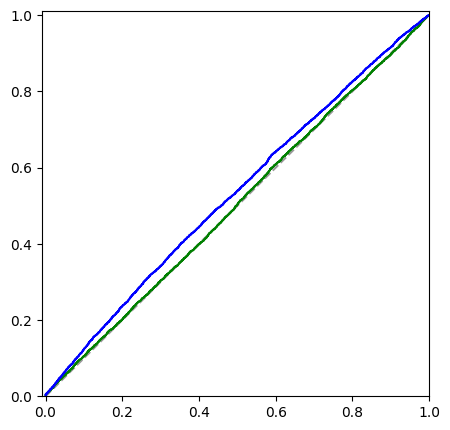

In [111]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], 'k--', alpha=.4)

tpr, fpr, _ = roc_curve(y_test, scores_test)
plt.plot(tpr, fpr, 'g')

tpr, fpr, _ = roc_curve(y_train, scores_train)
plt.plot(tpr, fpr, 'b')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

There seems to be no signal at all.

### Kernel features 
Stratis was suggesting something else: adapt the classifier to take $k(G, r)$ as input. By construction, this should work well.

In [150]:
def extract_kernel_features(auxiliary_data, synth_datasets, real_datasets):
    negative_datasets = []
    for dataset in real_datasets:
        # Use twice as many samples to make sure we have enough.
        candidates = auxiliary_data.sample(2*len(dataset))
        # Find all candidates that are *not* in the dataset.
        indices_to_keep = []
        for idx, record in enumerate(candidates):
            # Check if the record is in the real (or synthetic lol) dataset.
            if record in dataset:
                continue
            indices_to_keep.append(idx)
            if len(indices_to_keep) >= len(dataset):
                break
        negative_datasets.append(candidates.get_records(indices_to_keep))

    # We know have positive, negative and synthetic datasets.
    # We are going to compute the graph kernel between synthetic data and individual records
    X = []
    y = []
    for positive, negative, synth in zip(real_datasets, negative_datasets, synth_datasets):
        # The features we are going to compute are k(synth_dataset, record).
        # We first "fit" the kernel (s.t. kernel.transform:  g -> k(synth_dataset, g)).
        kernel.kernel.fit(_grak(synth.data))
        # Then apply it to positive and negative records.
        for record in positive + negative:
            X.append(kernel.kernel.transform(_grak(record.data))[0])
        y += [True] * len(positive)
        y += [False] * len(negative)
    return np.array(X), np.array(y)

Generate train and test datasets.

In [143]:
auxiliary_data = threat_model.atk_know_data.attacker_knowledge.aux_data

In [144]:
synth_datasets_train, _ = threat_model.generate_training_samples(100)

In [145]:
synth_datasets_test, _ = threat_model._generate_samples(100, training=False)

Do the kernel transformation.

In [151]:
kf_train, y_train = extract_kernel_features(auxiliary_data, synth_datasets_train, synth_datasets_train)

In [154]:
kf_test, y_test = extract_kernel_features(auxiliary_data, synth_datasets_test, synth_datasets_test)

Apply a simple classifier as attack (as a treat). Note that this _should_ work very well -- the task is to detect whether there is a 1 in the vector.

In [169]:
# model = LogisticRegression()
model = RandomForestClassifier()

In [170]:
model.fit(kf_train, y_train)

RandomForestClassifier()

In [171]:
scores_train = model.predict_proba(kf_train)[:,1]

In [172]:
scores_test = model.predict_proba(kf_test)[:,1]

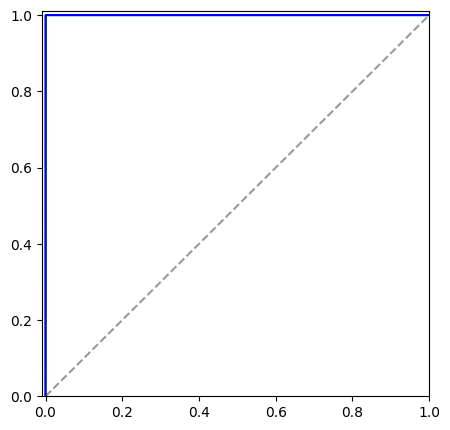

In [173]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], 'k--', alpha=.4)

tpr, fpr, _ = roc_curve(y_test, scores_test)
plt.plot(tpr, fpr, 'g')

tpr, fpr, _ = roc_curve(y_train, scores_train)
plt.plot(tpr, fpr, 'b')

plt.xlim([-0.01,1])
plt.ylim([0,1.01]);

OK so this works, at last! Next step is to try on a real generator.